# IN-PROGRESS...

## Kaggle Competion on Titanic Survivor Prediction
### https://www.kaggle.com/c/titanic/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [20]:
# Following data files were downloaded from respective Kaggle competition

train_data = pd.read_csv("train.csv")                           # 891 rows
test_data = pd.read_csv("test.csv")                             # 418 rows
gender_submission_data = pd.read_csv("gender_submission.csv")   # 418 rows

In [21]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [22]:
# Checks for na in train data
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [23]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [24]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [26]:
# Cabin collumn was revmoved because around 80% of data is missing from both test and training data.
# Columns PassengerId, Name, ticket, Fare and Embarked were also removed considering not relevant for prediction
train_data.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Embarked"], axis=1, inplace=True)
test_data.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Embarked"], axis=1, inplace=True)

In [27]:
# categorical data was encoded
train_data.replace({"Sex": {"male": 1, "female": 0}}, inplace=True)
test_data.replace({"Sex": {"male": 1, "female": 0}}, inplace=True)

In [44]:
# Now, the train_data looks like this.
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0
...,...,...,...,...,...,...
886,0,2,1,27.0,0,0
887,1,1,0,19.0,0,0
888,0,3,0,NaN,1,2
889,1,1,1,26.0,0,0


In [ ]:
# It was observed that around 20% of samples 

In [33]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

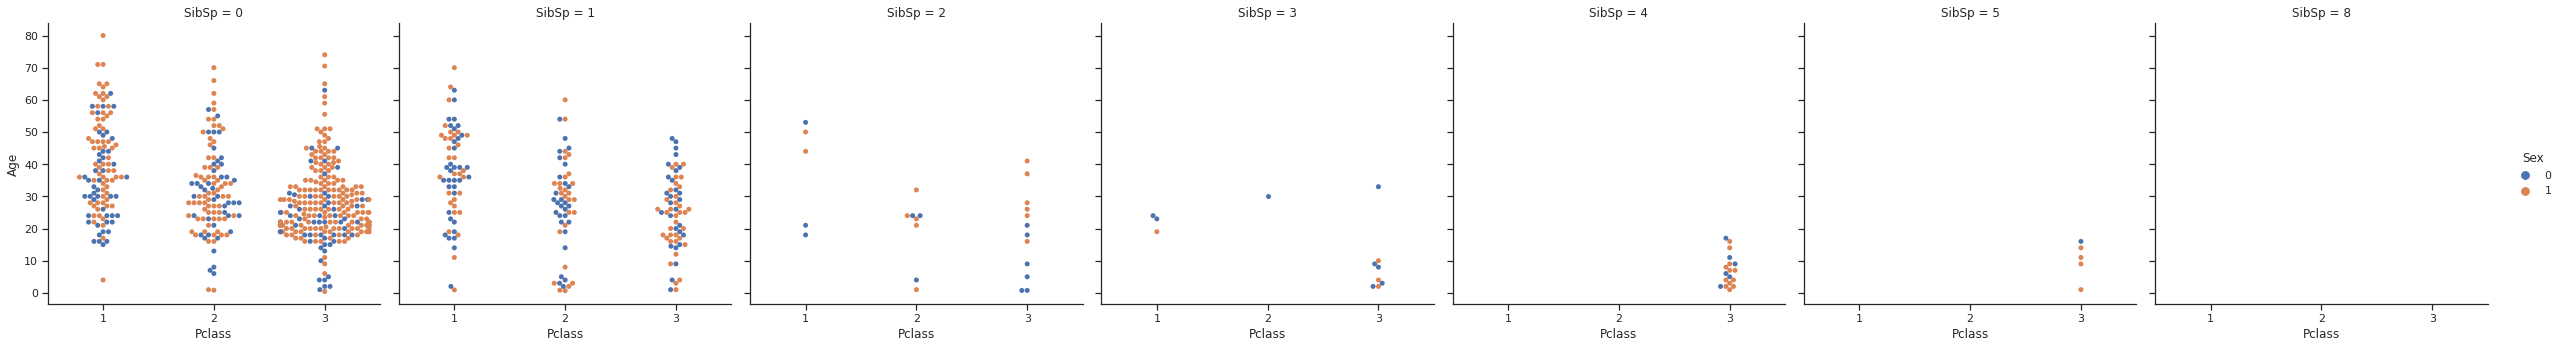

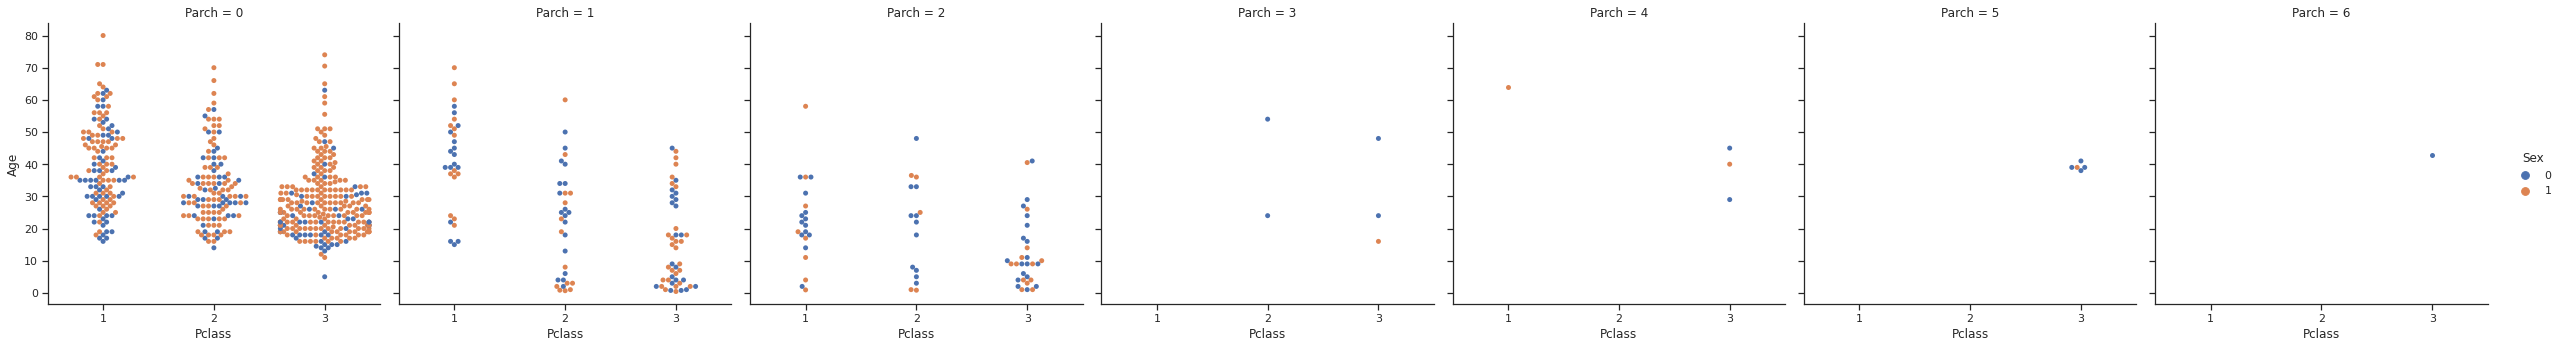

In [43]:
sns.catplot(x="Pclass", y="Age", hue="Sex", kind="swarm", col="SibSp", data=train_data);
sns.catplot(x="Pclass", y="Age", hue="Sex", kind="swarm", col="Parch", data=train_data);

## Let's build and improve the model over iterations
### First, build a simple model by removing 'na' records and few non-relavant columns "PassengerId", "Name" and "Cabin" at least for this simple model

In [170]:
x_train = train_data.copy()
x_train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
x_train.dropna(axis=0, inplace=True)

In [171]:
x_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


In [172]:
x_train.replace({"Sex": {"male": 1, "female": 0}, "Embarked": {"C": 1, "Q": 2, "S": 3}}, inplace=True)

In [173]:
x_train.dtypes

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object

In [174]:
x_train.Survived = x_train.Survived.astype('int32')
x_train.Pclass = x_train.Pclass.astype('float32')
x_train.Sex = x_train.Sex.astype('float32')
x_train.SibSp = x_train.SibSp.astype('float32')
x_train.Parch = x_train.Parch.astype('float32')
x_train.Fare = x_train.Fare.astype('float32')
x_train.Embarked = x_train.Embarked.astype('float32')

In [175]:
x_train = x_train.sample(frac=1)

In [176]:
x_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
447,1,1.0,1.0,34.0,0.0,0.0,26.549999,3.0
7,0,3.0,1.0,2.0,3.0,1.0,21.075001,3.0
313,0,3.0,1.0,28.0,0.0,0.0,7.895800,3.0
684,0,2.0,1.0,60.0,1.0,1.0,39.000000,3.0
652,0,3.0,1.0,21.0,0.0,0.0,8.433300,3.0
...,...,...,...,...,...,...,...,...
156,1,3.0,0.0,16.0,0.0,0.0,7.733300,2.0
322,1,2.0,0.0,30.0,0.0,0.0,12.350000,2.0
853,1,1.0,0.0,16.0,0.0,1.0,39.400002,3.0
20,0,2.0,1.0,35.0,0.0,0.0,26.000000,3.0


In [177]:
y_train = x_train.pop("Survived")

In [178]:
mean = x_train.mean()
std = x_train.std()

x_train -= mean
x_train /= std

In [179]:
x_validation = x_train[:200]
x_train = x_train[200:]

y_validation = y_train[:200]
y_train = y_train[200:]

In [180]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [182]:
epoch_count = 20
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epoch_count, batch_size=1)

Epoch 1/20
512/512 [==============================] - 2s 4ms/step - loss: 0.5201 - accuracy: 0.7480 - val_loss: 0.4529 - val_accuracy: 0.8050
Epoch 2/20
512/512 [==============================] - 2s 4ms/step - loss: 0.4710 - accuracy: 0.8008 - val_loss: 0.4791 - val_accuracy: 0.8050
Epoch 3/20
512/512 [==============================] - 2s 4ms/step - loss: 0.4597 - accuracy: 0.8184 - val_loss: 0.4842 - val_accuracy: 0.8100
Epoch 4/20
512/512 [==============================] - 2s 4ms/step - loss: 0.4492 - accuracy: 0.8145 - val_loss: 0.4267 - val_accuracy: 0.8500
Epoch 5/20
512/512 [==============================] - 2s 4ms/step - loss: 0.4373 - accuracy: 0.8125 - val_loss: 0.4932 - val_accuracy: 0.8100
Epoch 6/20
512/512 [==============================] - 2s 4ms/step - loss: 0.4424 - accuracy: 0.8301 - val_loss: 0.5022 - val_accuracy: 0.8100
Epoch 7/20
512/512 [==============================] - 2s 4ms/step - loss: 0.4440 - accuracy: 0.8320 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 

In [184]:
epoch_count = 20

In [187]:
len(history.history["loss"])

20

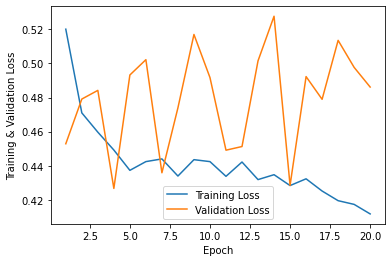

In [192]:
plt.plot(range(1, len(history.history["loss"])+1), history.history["loss"], label="Training Loss")
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Training & Validation Loss")
plt.legend()
plt.show()

In [27]:
train_data.Fare.sort_values(ignore_index=True)

0        0.0000
1        0.0000
2        0.0000
3        0.0000
4        0.0000
         ...   
886    263.0000
887    263.0000
888    512.3292
889    512.3292
890    512.3292
Name: Fare, Length: 891, dtype: float64

In [9]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [199]:
x_test = test_data.copy()

In [200]:
x_test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
x_test.replace({"Sex": {"male": 1, "female": 0}, "Embarked": {"C": 1, "Q": 2, "S": 3}}, inplace=True)

In [201]:
x_test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [202]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,2
1,3,0,47.0,1,0,7.0000,3
2,2,1,62.0,0,0,9.6875,2
3,3,1,27.0,0,0,8.6625,3
4,3,0,22.0,1,1,12.2875,3
...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,3
414,1,0,39.0,0,0,108.9000,1
415,3,1,38.5,0,0,7.2500,3
416,3,1,NaN,0,0,8.0500,3
